In [2]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download \
    -d sixhky/open-images-bus-trucks/
    !unzip -qq open-images-bus-trucks.zip
    !rm open-images-bus-trucks.zip

     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 56 kB 3.1 MB/s 
     |████████████████████████████████| 213 kB 8.3 MB/s 
     |████████████████████████████████| 10.1 MB 42.3 MB/s 
     |████████████████████████████████| 57 kB 4.9 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 


Saving kaggle.json to kaggle.json
kaggle.json
 96% 353M/367M [00:14<00:00, 24.5MB/s]
100% 367M/367M [00:15<00:00, 25.6MB/s]


In [4]:
from torch_snippets import *
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from custom_dataset import OpenDataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from utils import train_batch, validate_batch, get_model
from utils import decode_output
from utils import decode_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
IMAGE_ROOT = '/content/images/images'
DF_RAW = df = pd.read_csv('/content/df.csv')

DF_RAW = DF_RAW.sample(1000)
df = DF_RAW

DF_RAW.head(3)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
10028,632d84ab679aae26,activemil,Truck,1,0.236875,0.860625,0.047081,0.917138,1,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3129,16b2639dc73c2d98,activemil,Truck,1,0.159375,0.953750,0.394995,0.924918,1,0,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9609,5ea6b566f860b8c7,activemil,Truck,1,0.193750,0.660625,0.291262,0.728155,0,0,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [6]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [15]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
print(len(trn_df), len(val_df))

train_ds = OpenDataset(trn_df, label2target=label2target, image_dir=IMAGE_ROOT)
test_ds = OpenDataset(val_df, label2target=label2target, image_dir=IMAGE_ROOT)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

899 101


In [16]:
model = get_model(num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 20
log = Report(n_epochs)

In [17]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        
    if (epoch+1)%(n_epochs//n_epochs)==0: 
        log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.203	trn_loc_loss: 0.094	trn_regr_loss: 0.085	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.007	val_loss: 0.151	val_loc_loss: 0.073	val_regr_loss: 0.063	val_objectness_loss: 0.010	val_rpn_box_reg_loss: 0.005	(466.12s - 8856.29s remaining)
EPOCH: 2.000	trn_loss: 0.137	trn_loc_loss: 0.065	trn_regr_loss: 0.059	trn_objectness_loss: 0.007	trn_rpn_box_reg_loss: 0.005	val_loss: 0.148	val_loc_loss: 0.071	val_regr_loss: 0.059	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.005	(928.03s - 8352.31s remaining)
EPOCH: 3.000	trn_loss: 0.106	trn_loc_loss: 0.050	trn_regr_loss: 0.048	trn_objectness_loss: 0.004	trn_rpn_box_reg_loss: 0.004	val_loss: 0.159	val_loc_loss: 0.077	val_regr_loss: 0.060	val_objectness_loss: 0.017	val_rpn_box_reg_loss: 0.005	(1389.97s - 7876.49s remaining)
EPOCH: 4.000	trn_loss: 0.086	trn_loc_loss: 0.039	trn_regr_loss: 0.040	trn_objectness_loss: 0.003	trn_rpn_box_reg_loss: 0.004	val_loss: 0.166	val_loc_loss: 0.086	val_regr_loss: 0.055	val_objectnes

100%|██████████| 121/121 [00:00<00:00, 670.00it/s]


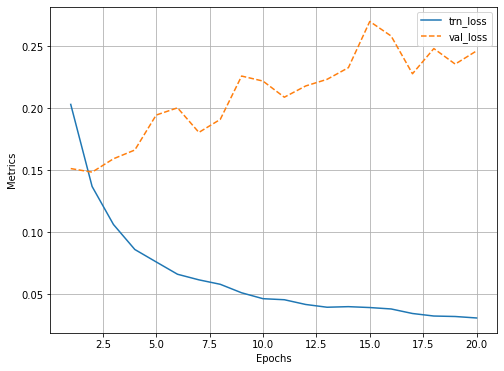

In [18]:
log.plot_epochs(['trn_loss','val_loss'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


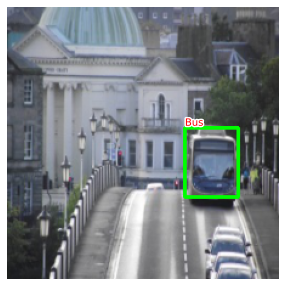

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


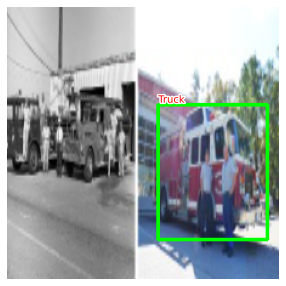

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


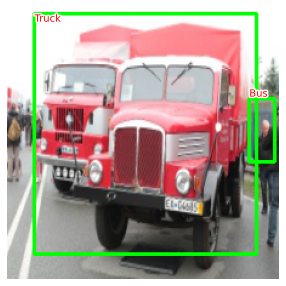

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


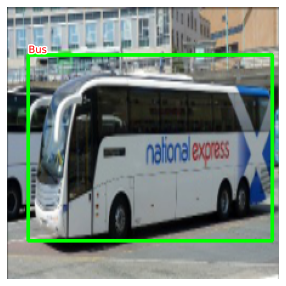

In [23]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==1: 
        break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output, target2label)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)